In [1]:
# This script pickles polymorphism info

from utils import sample_utils as su, config, parse_midas_data, stats_utils, sfs_utils
import pylab, sys, numpy as np, random, math
from utils import temporal_changes_utils
from collections import defaultdict
import bz2
import pickle

# Modification event threshold (config: 20)
modification_difference_threshold = config.modification_difference_threshold

# Replacement event threshold (config: 500)
replacement_difference_threshold = config.replacement_difference_threshold

# Load subject and sample metadata
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_country_map = su.parse_sample_country_map()
sample_subject_map = su.parse_sample_subject_map()
sample_cohort_map = su.parse_sample_cohort_map()
sys.stderr.write("Done!\n")

# Samples
all_samples = su.get_sample_names('all') # Note: c's removed
olm_samples = su.get_sample_names('olm')
mother_samples = su.get_sample_names('mother')
hmp_samples = su.get_sample_names('hmp')

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# Pickle directory
pickle_dir = "%s/pickles" % config.data_directory

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

Loading sample metadata...
Done!


In [2]:
# Dictionary: sample(-species pair) -> within-sample polymorphism (average estimate)
sample_species_polymorphism_dict = defaultdict(dict)

for species_name in good_species_list:
	
	print("Working on " + species_name)
	
	# Store within-host polymorphism for ALL samples
	_, sfs_map = parse_midas_data.parse_within_sample_sfs(species_name, allowed_variant_types=set(['4D']))
	for sample in all_samples:		
		if sample not in sfs_map: # TODO
			continue
		within_sites, between_sites, total_sites = sfs_utils.calculate_polymorphism_rates_from_sfs_map(sfs_map[sample])
		try:
			within_rate_lower, within_rate_upper = stats_utils.calculate_poisson_rate_interval(within_sites, total_sites,alpha=0.05) # 95% CI
		except:
			continue
		sample_species_polymorphism_dict[sample][species_name] = (within_rate_lower + within_rate_upper)/2.0

# Pickle things
pickle.dump(sample_species_polymorphism_dict, open("%s/sample_species_polymorphism_dict.pkl" % (pickle_dir), 'wb'))

Working on Escherichia_coli_58110
Working on Bacteroides_vulgatus_57955
Working on Enterococcus_faecalis_56297
Working on Bifidobacterium_longum_57796
Working on Bifidobacterium_breve_57133
Working on Klebsiella_pneumoniae_54788
Working on Staphylococcus_epidermidis_57523
Working on Bacteroides_uniformis_57318
Working on Bifidobacterium_bifidum_55065
Working on Bacteroides_ovatus_58035
Working on Veillonella_parvula_57794
Working on Alistipes_putredinis_61533
Working on Bacteroides_fragilis_54507
Working on Prevotella_copri_61740
Working on Clostridium_perfringens_56840
Working on Enterobacter_cloacae_58148
Working on Bacteroides_stercoris_56735
Working on Veillonella_parvula_58184
Working on Klebsiella_oxytoca_56762
Working on Parabacteroides_distasonis_56985
Working on Veillonella_atypica_58169
Working on Citrobacter_freundii_56148
Working on Klebsiella_oxytoca_57801
Working on Streptococcus_salivarius_58037
Working on Clostridium_paraputrificum_59909
Working on Enterobacter_aerogene

In [3]:
sample_species_polymorphism_dict = pickle.load(open("%s/sample_species_polymorphism_dict.pkl" % (pickle_dir), 'rb'))

In [5]:
from matplotlib import pyplot as plt

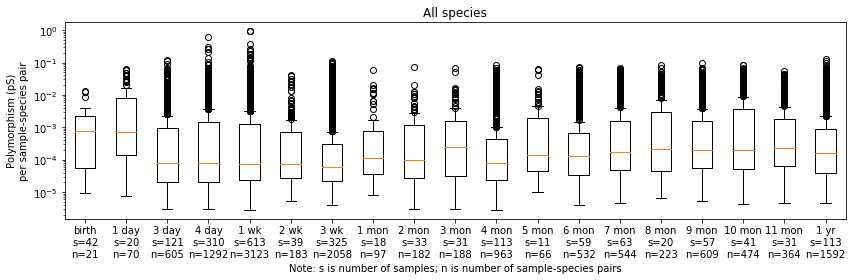

In [98]:
mi_tp_sample_dict, infant_tps_ordered = su.get_mi_tp_sample_dict(exclude_cohorts = ['olm'], binned = True)
mother_tps_ordered = sorted(mi_tp_sample_dict['mother'].keys())
tps_ordered_dict = {'mother': mother_tps_ordered, 'infant': infant_tps_ordered}
# tps_ordered_dict['infant'].remove('6 day')

# Firstly reproduce plot with all species
# And also store distribution of data by cohorts

fig, ax = plt.subplots(figsize=(12,4))

ordered_infant_tps = tps_ordered_dict['infant']
cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

polymorphism_by_tp_dict = defaultdict(list)
num_sample_species_by_cohort_tp = {c: {tp: 0 for tp in ordered_infant_tps} for c in cohorts}
num_samples_by_cohort_tp = {c: {tp: 0 for tp in ordered_infant_tps} for c in cohorts}

for tp in mi_tp_sample_dict['infant']:
    for sample in mi_tp_sample_dict['infant'][tp]:
        # Assume no Olm samples
        cohort = sample_cohort_map[sample]
        num_samples_by_cohort_tp[cohort][tp] += 1
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            polymorphism_by_tp_dict[tp].append(polymorphism)
            num_sample_species_by_cohort_tp[cohort][tp] += 1

labels = []
data = []
ordered_infant_tps.remove('6 day')

for tp in ordered_infant_tps:
    data.append(polymorphism_by_tp_dict[tp])
    num_samples = np.sum([num_samples_by_cohort_tp[cohort][tp] for cohort in cohorts])
    num_sample_species = np.sum([num_sample_species_by_cohort_tp[cohort][tp] for cohort in cohorts])
    labels.append("%s\ns=%i\nn=%i" % (tp, num_samples, num_sample_species))

ax.set_yscale('log')
ax.boxplot(data)
ax.set_title('All species')
ax.set_xticklabels(labels)
ax.set_ylabel("Polymorphism (pS)\nper sample-species pair")
ax.set_xlabel("Note: s is number of samples; n is number of sample-species pairs")

plt.tight_layout()
plt.show()

fig.savefig('%s/polymorphism_per_sample_species_by_tp_infant.pdf' % plot_dir, bbox_inches='tight')

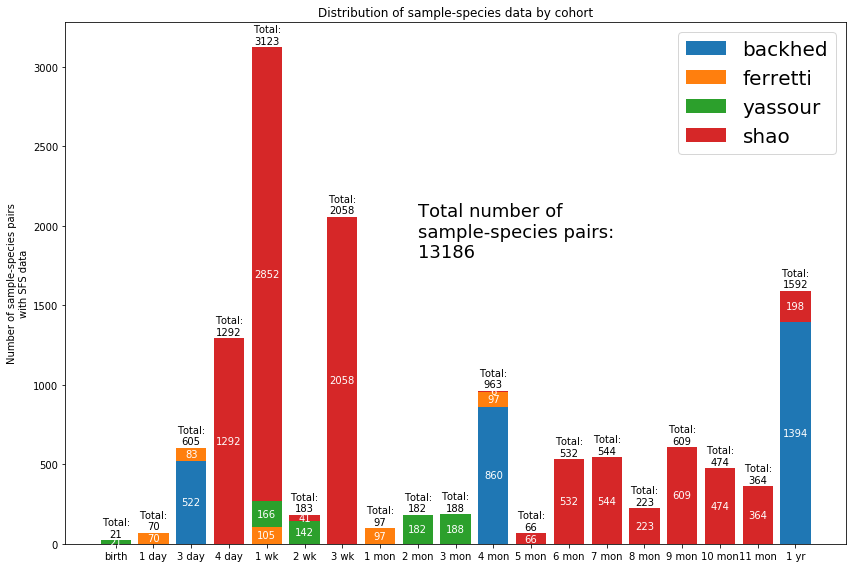

In [94]:
# Show distribution of data by cohorts

fig, ax = plt.subplots(figsize=(12,8))

cums = np.zeros(len(ordered_infant_tps))

for cohort in cohorts:
    nums = []
    for tp in ordered_infant_tps:
        nums.append(num_sample_species_by_cohort_tp[cohort][tp])
    rects = ax.bar(ordered_infant_tps, nums, bottom=cums, label=cohort)
    for i in range(len(nums)):
        mid = cums[i] + (nums[i] / 2.0)
        if nums[i] != 0:
            ax.text(i, mid-20, nums[i], ha='center', color='white')
    cums += np.array(nums)

for i in range(len(nums)):
    ax.text(i, cums[i] + 20, 'Total:\n%i' % (cums[i]), ha='center')

# ax.set_yscale('log')
ax.text(8, 1800, 'Total number of\nsample-species pairs:\n%i' % (np.sum(cums)), fontsize=18)

# ax.set_yscale('log')
ax.set_title('Distribution of sample-species data by cohort')
ax.set_xticklabels(ordered_infant_tps)
ax.set_ylabel("Number of sample-species pairs\nwith SFS data")
ax.legend(fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig('%s/distribution_sample_species_by_cohort.pdf' % plot_dir, bbox_inches='tight')

In [86]:
x = []
for sample in su.get_sample_names('infant'):
    if sample not in olm_samples:
        x.append(sample)
print(len(x))

2062


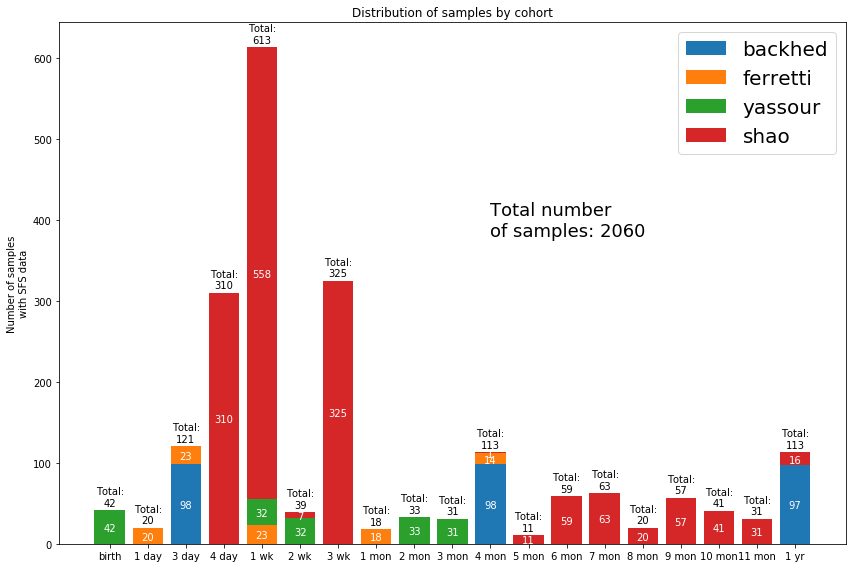

In [88]:
# Show distribution of data by cohorts

fig, ax = plt.subplots(figsize=(12,8))

cums = np.zeros(len(ordered_infant_tps))

for cohort in cohorts:
    nums = []
    for tp in ordered_infant_tps:
        nums.append(num_samples_by_cohort_tp[cohort][tp])
    rects = ax.bar(ordered_infant_tps, nums, bottom=cums, label=cohort)
    for i in range(len(nums)):
        mid = cums[i] + (nums[i] / 2.0)
        if nums[i] != 0:
            ax.text(i, mid-5, nums[i], ha='center', color='white')
    cums += np.array(nums)

for i in range(len(nums)):
    ax.text(i, cums[i] + 5, 'Total:\n%i' % (cums[i]), ha='center')

# ax.set_yscale('log')
ax.text(10, 380, 'Total number\nof samples: %i' % (np.sum(cums)), fontsize=18)
ax.set_title('Distribution of samples by cohort')
ax.set_xticklabels(ordered_infant_tps)
ax.set_ylabel("Number of samples\nwith SFS data")
ax.legend(fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig('%s/distribution_samples_by_cohort.pdf' % plot_dir, bbox_inches='tight')

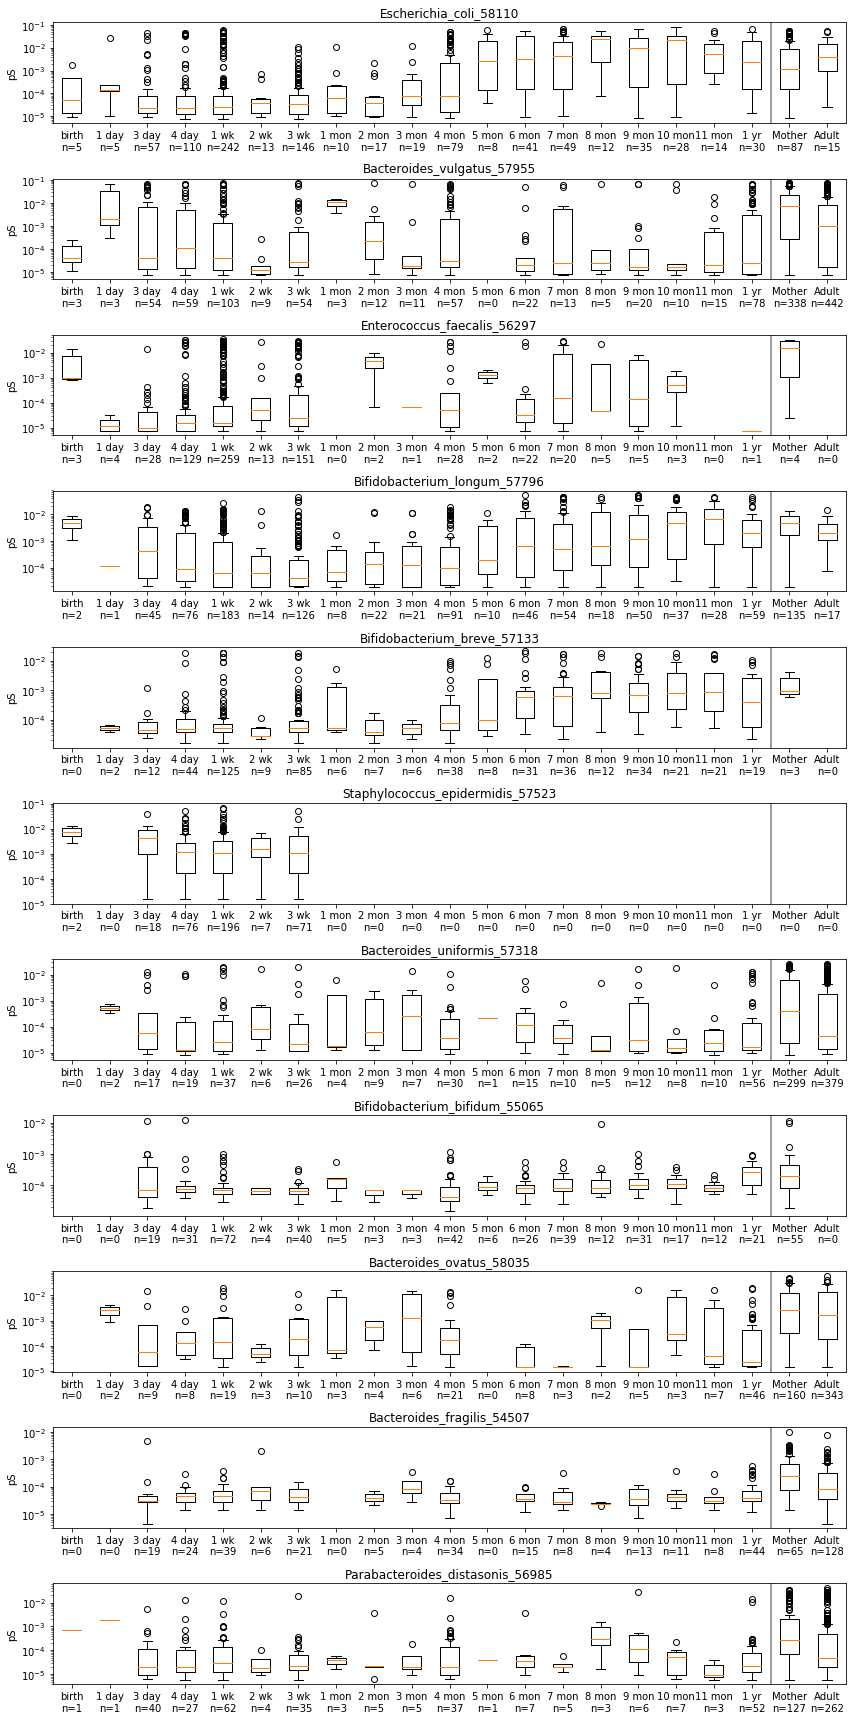

In [99]:
fig, ax = plt.subplots(11, 1, figsize=(12,24))

species_list = good_species_list[0:5] + good_species_list [6:10] + [good_species_list[12]] + [good_species_list[19]]

all_tps = tps_ordered_dict['infant'] + ['Mother', 'Adult']

for i in range(len(species_list)):
    desired_species = species_list[i]
    data = []
    labels = []
    
    polymorphism_by_tp_dict = defaultdict(list)
    
    for sample in mother_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Mother'].append(polymorphism)
    
    for sample in hmp_samples:
        for species in sample_species_polymorphism_dict[sample]:
            polymorphism = sample_species_polymorphism_dict[sample][species]
            if species == desired_species:
                polymorphism_by_tp_dict['Adult'].append(polymorphism)
    
    for tp in mi_tp_sample_dict['infant']:
        for sample in mi_tp_sample_dict['infant'][tp]:
            for species in sample_species_polymorphism_dict[sample]:
                polymorphism = sample_species_polymorphism_dict[sample][species]
                if species == desired_species:
                    polymorphism_by_tp_dict[tp].append(polymorphism)
    
    for tp in all_tps:
        polymorphisms = polymorphism_by_tp_dict[tp]
        data.append(polymorphisms)
        labels.append("%s\nn=%i" % (tp, len(polymorphisms)))
    
    ax[i].set_yscale('log')
    ax[i].boxplot(data)
    ax[i].set_title('%s' % desired_species)
    ax[i].axvline(x=19.5, color='gray')
    ax[i].set_ylabel("pS")
    ax[i].set_xticklabels(labels)

plt.tight_layout()
plt.show()